In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from matplotlib import style
style.use("ggplot")

from linearmodels.panel import PanelOLS
import statsmodels.formula.api as smf


In [36]:
time = range(1980, 2010)
cohorts = [1985,1994,2000,2011]
units = range(1, 100+1)
treat_prop = 0.5

np.random.seed(3)

df = pd.DataFrame(dict(
    year = np.tile(time, len(units)),
    unit = np.repeat(units, len(time)),
    cohort = np.repeat(np.random.choice(cohorts, len(units)), len(time)),
    unit_fe = np.repeat(np.random.normal(size=len(units)), len(time)),
    time_fe = np.tile(np.random.normal(size=len(time)), len(units)),
)).assign(
    trend = lambda d: (d["year"] - d["year"].min())/8
).assign(
    treat = lambda d: (d["year"] >= d["cohort"]).astype(int),
    y0 = lambda d: 10 + d["trend"] + d["unit_fe"] + 0.1*d["time_fe"],
).assign(
    y1 = lambda d: d["y0"] + 1
).assign(
    tau = lambda d: d["y1"] - d["y0"],
    outcome = lambda d: np.where(d["treat"] == 1, d["y1"], d["y0"])
)

df.head(21)

,year,unit,cohort,unit_fe,time_fe,trend,treat,y0,y1,tau,outcome
0,1980,1,2000,-0.59665,-0.716026,0.000,0,9.331748,10.331748,1.0,9.331748
1,1981,1,2000,-0.59665,0.731466,0.125,0,9.601497,10.601497,1.0,9.601497
2,1982,1,2000,-0.59665,0.425967,0.250,0,9.695947,10.695947,1.0,9.695947
3,1983,1,2000,-0.59665,-0.149014,0.375,0,9.763449,10.763449,1.0,9.763449
4,1984,1,2000,-0.59665,0.835844,0.500,0,9.986935,10.986935,1.0,9.986935
5,1985,1,2000,-0.59665,0.492119,0.625,0,10.077562,11.077562,1.0,10.077562
6,1986,1,2000,-0.59665,-0.862308,0.750,0,10.067120,11.067120,1.0,10.067120
7,1987,1,2000,-0.59665,1.071684,0.875,0,10.385519,11.385519,1.0,10.385519
8,1988,1,2000,-0.59665,-1.220902,1.000,0,10.281260,11.281260,1.0,10.281260
9,1989,1,2000,-0.59665,0.059615,1.125,0,10.534312,11.534312,1.0,10.534312


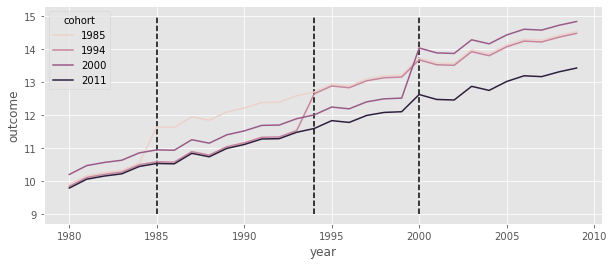

In [47]:
plt.figure(figsize=(10,4))
[plt.vlines(x=c, ymin=9, ymax=15, color="black", ls="dashed") for c in cohorts[:-1]]
sns.lineplot(
    data=df.groupby(["cohort", "year"])["outcome"].mean().reset_index(),
    x="year",
    y = "outcome",
    hue="cohort",
);

In [48]:
formula = f"""outcome ~ treat + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=df.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,1.0000,2.248e-16,4.448e+15,0.0000,1.0000,1.0000


## Death

In [9]:
def sample_x(years, units, parallel=True):
    
    x_start = np.random.normal(0, 1, units)
    
    x_trend = np.random.normal(0, 1, (1 if parallel else units))
    
    years_array = np.array(years)

    return (pd.DataFrame(x_start.reshape(-1,1) + np.outer(x_trend, ((years_array - years_array.min()))),
                         columns=years)
            .reset_index()
            .melt(id_vars=["index"])
            .rename(columns={"index": "unit", "variable":"year", "value": "x"})
            .astype(float)
           )
    

def generate_data(units = 1000,
                  mu_true=1,
                  changing_mu=False,
                  years = range(1980, 2010+1),
                  states = range(1,41),
                  cohorts = [1986,1992,1998,2004],
                  trend=False,
                  covariates=False,
                  covariates_th=False,
                  parallel_x=False,
                  seed=123):

    unit = pd.DataFrame(dict(
        unit = range(1, units+1),
        state = np.random.choice(states, units),
        mu = mu_true,
    )).assign(
        unit_fe = lambda d: np.random.normal(d["state"]/5, 1, units)     
    )

    year = pd.DataFrame(dict(
        year = years,
    )).assign(year_fe = lambda d: np.random.normal(0, 1, d.shape[0]))


    treat_taus = pd.DataFrame(dict(
        state = np.random.choice(states, len(states), replace = False),
        cohort_year = np.sort(np.repeat(cohorts, len(states)//len(cohorts)))
    ))
    
    if changing_mu:
        treatment_fn = lambda d: np.where(d["year"] >= d["cohort_year"], d["mu"], 0)
    else:
        treatment_fn = lambda d: np.where(d["year"] == d["cohort_year"], d["mu"], 0)
        
    x_data = sample_x(years, units, parallel=parallel_x)

    return (pd.DataFrame(dict(unit = range(1, units+1), key=1))
            .merge(pd.DataFrame(dict(year = years, key=1)))
            .drop(columns=["key"])
            .merge(unit)
            .merge(year)
            .merge(treat_taus)
            .merge(x_data)
            .assign(error = lambda d: np.random.normal(0, 1, d.shape[0]))
            .assign(treat = lambda d: np.where(d["year"] >= d["cohort_year"], 1, 0))
            .assign(tau = treatment_fn)
            .assign(trend = lambda d: 0.7*(d["year"] - years[0]))
            .assign(year_fe = lambda d: d["year_fe"] + 0.1*(d["year"] - d["cohort_year"]))
            .sort_values(["unit", "year"])
            .assign(true_effect = lambda d: d.groupby("unit")["tau"].cumsum())
            .assign(outcome = lambda d: (20
                                         + 2010 - d["cohort_year"] 
                                         + d["unit_fe"]
                                         + (d["x"] if covariates else 0)
                                         + (0.1*(d["x"] - d["x"].mean())*d["true_effect"] if (covariates and covariates_th) else 0)
                                         + d["year_fe"] 
                                         + d["true_effect"] 
                                         + (d["trend"] if trend else 0)
                                         + d["error"]))
            .assign(relative_year = lambda d: d["year"] - d["cohort_year"])
            .assign(relative_year_str = lambda d: abs(d["relative_year"]).astype("str"))
            .assign(relative_year_str = lambda d: np.where(d["relative_year"] < 0, "n"+d["relative_year_str"], "p"+d["relative_year_str"]))
            .drop(columns=["mu", "state", "unit_fe", "year_fe", "error", "trend", "tau"] + (["x"] if not covariates else []))
            
    )

## Staggered Addoption

In [10]:
np.random.seed(123)

cohorts = [1986,1992,1998,2004]
data = generate_data(1000, cohorts = cohorts,
                     mu_true=10, changing_mu=False, trend=True, covariates=False, parallel_x=False)

data.head()

,unit,year,cohort_year,treat,true_effect,outcome,relative_year,relative_year_str
0,1,1980,1986,0,0,44.207389,-6,n6
28,1,1981,1986,0,0,44.406033,-5,n5
56,1,1982,1986,0,0,48.629382,-4,n4
84,1,1983,1986,0,0,48.902241,-3,n3
112,1,1984,1986,0,0,47.321270,-2,n2


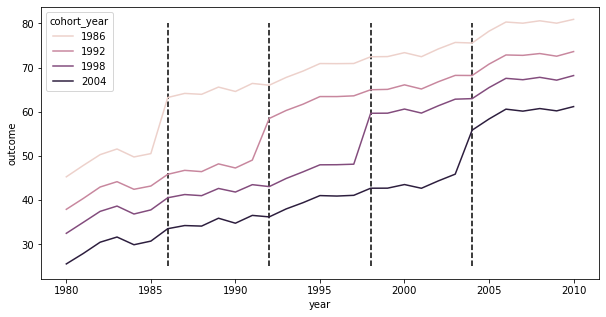

In [11]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
[plt.vlines(c, 25, 80, color="black", linestyles="--") for c in cohorts];

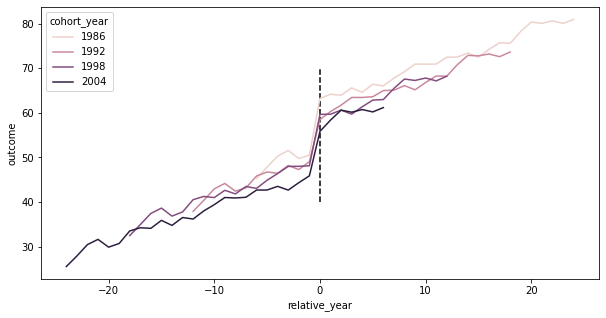

In [12]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["relative_year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="relative_year",
    y="outcome",
    hue="cohort_year",
)
plt.vlines(0, 40, 70, color="black", linestyles="--");
 

In [13]:
formula = f"""outcome ~ treat + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,10.000,0.0206,486.46,0.0000,9.9597,10.040


## Trend in The Effect

In [14]:
np.random.seed(123)

cohorts = [1986,1992,1998,2004]
data = generate_data(1000, cohorts = cohorts,
                     mu_true=1, changing_mu=True, trend=False, covariates=False, parallel_x=False)

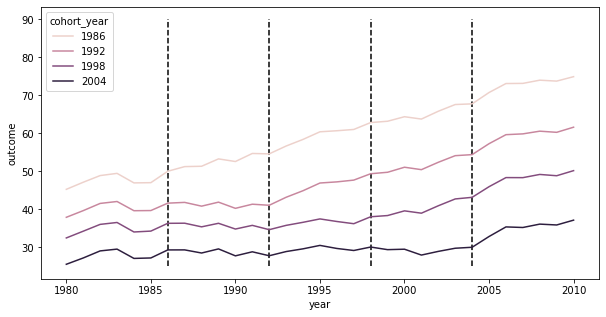

In [15]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
[plt.vlines(c, 25, 90, color="black", linestyles="--") for c in cohorts];

### Diff in Diff

In [16]:
formula = f"""outcome ~ treat + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,0.1719,0.0577,2.9787,0.0029,0.0588,0.2850


### Event Study Desing

In [18]:
k = 5
event_data = (data
              .assign(pre = lambda d: np.where(d["relative_year"] < -5, 1, 0))
              .assign(post = lambda d: np.where(d["relative_year"] > 5, 1, 0))
              .join(pd.get_dummies(data["relative_year_str"])))

In [19]:
event_data.head()

,unit,year,cohort_year,treat,true_effect,outcome,relative_year,relative_year_str,pre,post,...,p22,p23,p24,p3,p4,p5,p6,p7,p8,p9
0,1,1980,1986,0,0,44.207389,-6,n6,1,0,...,0,0,0,0,0,0,0,0,0,0
28,1,1981,1986,0,0,43.706033,-5,n5,0,0,...,0,0,0,0,0,0,0,0,0,0
56,1,1982,1986,0,0,47.229382,-4,n4,0,0,...,0,0,0,0,0,0,0,0,0,0
84,1,1983,1986,0,0,46.802241,-3,n3,0,0,...,0,0,0,0,0,0,0,0,0,0
112,1,1984,1986,0,0,44.521270,-2,n2,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
formula = f"""outcome ~ 
pre + post +
{'n'+'+n'.join(map(str, reversed(range(2, k+1))))} +
{'p'+'+p'.join(map(str, range(0, k+1)))} +
EntityEffects + TimeEffects"""


mod = PanelOLS.from_formula(formula, data=event_data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

In [21]:
params_df = pd.DataFrame(dict(estimated_effect=list(result.params.values) + [0],
                              relative_year_str=list(result.params.index) + ["n1"]))

params_df

,estimated_effect,relative_year_str
0,5.425269,pre
1,6.433745,post
2,1.592385,n5
3,1.137825,n4
4,0.763380,n3
5,0.378952,n2
6,1.400221,p0
7,0.957692,p1
8,1.382033,p2
9,1.730707,p3


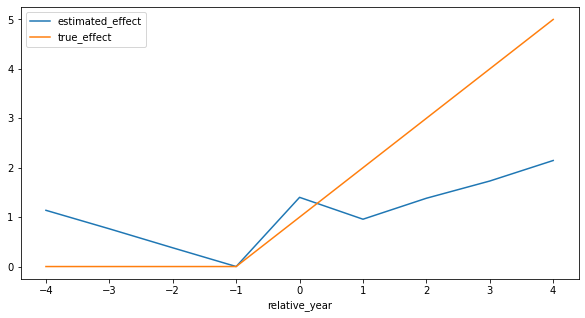

In [22]:
(event_data
 .query("relative_year< 5").query("relative_year>-5")
 .merge(params_df, on=["relative_year_str"], how="left")
 .groupby("relative_year")[["estimated_effect", "true_effect"]]
 .mean()
 .plot(figsize=(10,5)));

## Covariates

### Parallel Covariates

In [1]:
def sample_x(years, units, parallel=True):
    
    x_start = np.random.normal(0, 1, units)
    
    x_trend = np.random.normal(0, 1, (1 if parallel else units))
    
    years_array = np.array(years)

    return (
        pd.DataFrame(x_start.reshape(-1,1) + np.outer(x_trend, (0.1*(years_array - years_array.min()))),
                         columns=years)
            .reset_index()
            .melt(id_vars=["index"])
            .rename(columns={"index": "unit", "variable":"year", "value": "x"})
            .astype(float)
           )
    

def generate_data(units = 1000,
                  mu_true=1,
                  changing_mu=False,
                  years = range(1980, 2010+1),
                  states = range(1,41),
                  cohorts = [1986,1992,1998,2004],
                  trend=False,
                  covariates=False,
                  covariates_th=False,
                  parallel_x=False,
                  seed=123):

    unit = pd.DataFrame(dict(
        unit = range(1, units+1),
        state = np.random.choice(states, units),
        mu = mu_true,
    )).assign(
        unit_fe = lambda d: np.random.normal(d["state"]/5, 1, units)     
    )

    year = pd.DataFrame(dict(
        year = years,
    )).assign(year_fe = lambda d: np.random.normal(0, 1, d.shape[0]))


    treat_taus = pd.DataFrame(dict(
        state = np.random.choice(states, len(states), replace = False),
        cohort_year = np.sort(np.repeat(cohorts, len(states)//len(cohorts)))
    ))
    
    if changing_mu:
        treatment_fn = lambda d: np.where(d["year"] >= d["cohort_year"], d["mu"], 0)
    else:
        treatment_fn = lambda d: np.where(d["year"] == d["cohort_year"], d["mu"], 0)
        
    x_data = sample_x(years, units, parallel=parallel_x)

    return (pd.DataFrame(dict(unit = range(1, units+1), key=1))
            .merge(pd.DataFrame(dict(year = years, key=1)))
            .drop(columns=["key"])
            .merge(unit)
            .merge(year)
            .merge(treat_taus)
            .merge(x_data)
            .assign(error = lambda d: np.random.normal(0, 1, d.shape[0]))
            .assign(treat = lambda d: np.where(d["year"] >= d["cohort_year"], 1, 0))
            .assign(tau = treatment_fn)
            .assign(trend = lambda d: 0.7*(d["year"] - years[0]))
            .assign(year_fe = lambda d: d["year_fe"] + 0.1*(d["year"] - d["cohort_year"]))
            .sort_values(["unit", "year"])
            .assign(true_effect = lambda d: d.groupby("unit")["tau"].cumsum())
            .assign(outcome = lambda d: (20
                                         + 2010 - d["cohort_year"] 
                                         + d["unit_fe"]
                                         + (d["x"] if covariates else 0)
                                         + ((d["x"] - d["x"].mean())*d["true_effect"] if (covariates and covariates_th) else 0)
                                         + d["year_fe"] 
                                         + d["true_effect"] 
                                         + (d["trend"] if trend else 0)
                                         + d["error"]))
            .assign(relative_year = lambda d: d["year"] - d["cohort_year"])
            .assign(relative_year_str = lambda d: abs(d["relative_year"]).astype("str"))
            .assign(relative_year_str = lambda d: np.where(d["relative_year"] < 0, "n"+d["relative_year_str"], "p"+d["relative_year_str"]))
            .drop(columns=["mu", "state", "unit_fe", "year_fe", "error", "trend", "tau"] + (["x"] if not covariates else []))
            
    )

In [2]:
def sample_x(years, units, parallel=True):
    
    x_start = np.random.normal(0, 5, units)
    
    x_trend = np.random.normal(0, 1, (1 if parallel else units))
    
    years_array = np.array(years)

    return (pd.DataFrame(x_start.reshape(-1,1) + np.outer(x_trend, ((years_array - years_array.min()))),
                         columns=years)
            .reset_index()
            .melt(id_vars=["index"])
            .rename(columns={"index": "unit", "variable":"year", "value": "x"})
            .astype(float)
           )

In [3]:
np.random.seed(1)

data = generate_data(units = 100,
                     years = range(1980, 1988),
                     cohorts = [1984,1992],
                     mu_true=10,
                     changing_mu=False,
                     trend=False,
                     covariates=True,
                     parallel_x=False
                    )

NameError: name 'np' is not defined

In [93]:
data.head(10)

,unit,year,cohort_year,x,treat,true_effect,outcome,relative_year,relative_year_str
0,1,1980,1984,-9.481805,0,0,44.534872,-4,n4
3,1,1981,1984,-10.215076,0,0,44.090856,-3,n3
6,1,1982,1984,-10.948348,0,0,44.550089,-2,n2
9,1,1983,1984,-11.681619,0,0,43.771124,-1,n1
12,1,1984,1984,-12.414891,1,10,53.912338,0,p0
15,1,1985,1984,-13.148163,1,10,51.879325,1,p1
18,1,1986,1984,-13.881434,1,10,51.473633,2,p2
21,1,1987,1984,-14.614706,1,10,49.540601,3,p3
24,2,1980,1992,-3.234583,0,0,34.835134,-12,n12
28,2,1981,1992,-2.398579,0,0,35.615926,-11,n11


<AxesSubplot:xlabel='year', ylabel='outcome'>

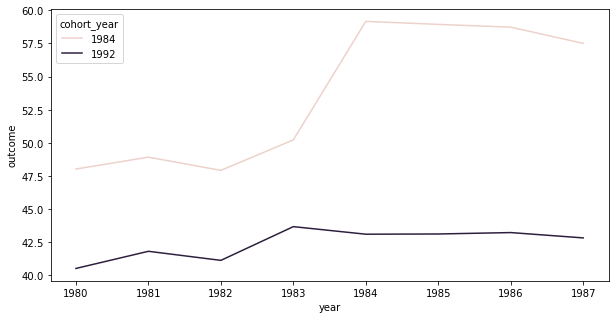

In [94]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
# [plt.vlines(c, 25, 90, color="black", linestyles="--") for c in cohorts];

<AxesSubplot:xlabel='year', ylabel='demean_x'>

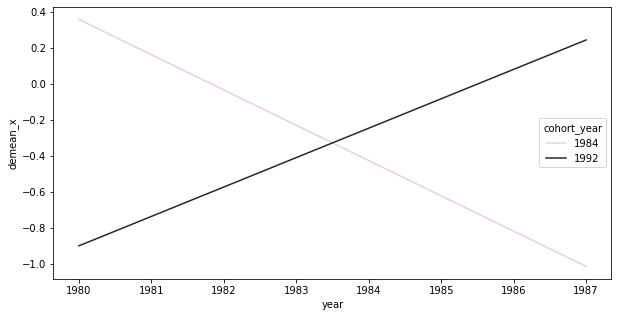

In [95]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=(data
          .assign(demean_x = data["x"] - data.groupby("unit")["x"].transform("mean") - data.groupby("year")["x"].transform("mean"))
          .groupby(["year", "cohort_year"])[["demean_x"]].mean().reset_index()),
    x="year",
    y="demean_x",
    hue="cohort_year",
)

In [96]:
formula = f"""outcome ~ treat + x + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,9.9747,0.1501,66.438,0.0000,9.6800,10.270
x,1.0000,0.0180,55.511,0.0000,0.9647,1.0354


### Non Parallel Covariates

In [19]:
np.random.seed(123)

cohorts = [1986,1992,1998,2004]
data = generate_data(1000, cohorts = cohorts,
                     mu_true=10, changing_mu=False, trend=False, covariates=True, parallel_x=False)

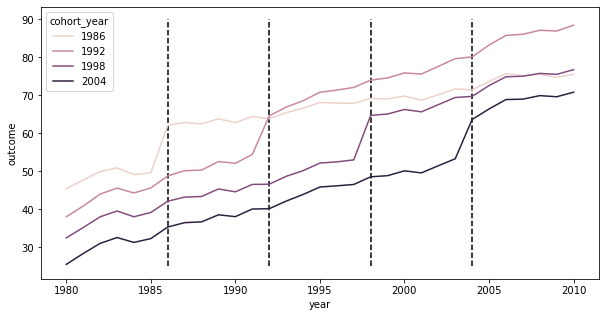

In [20]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
[plt.vlines(c, 25, 90, color="black", linestyles="--") for c in cohorts];

<AxesSubplot:xlabel='year', ylabel='x'>

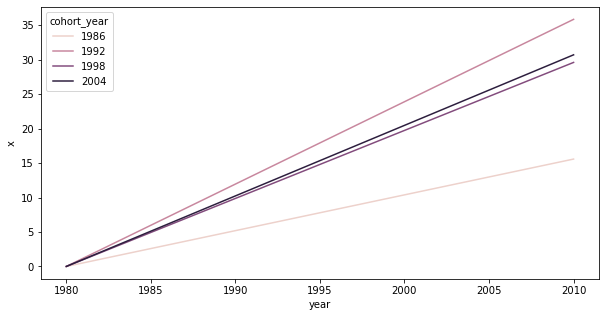

In [21]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["x"]].mean().reset_index(),
    x="year",
    y="x",
    hue="cohort_year",
)

In [22]:
formula = f"""outcome ~ treat + x + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,9.9865,0.0211,472.84,0.0000,9.9451,10.028
x,0.9999,0.0002,4975.7,0.0000,0.9996,1.0003


### Treatment Effect Heterogeneity

In [23]:
np.random.seed(123)

cohorts = [1986,1992,1998,2004]
data = generate_data(10, cohorts = cohorts,
                     mu_true=10, changing_mu=False, trend=False, covariates=True, parallel_x=True, covariates_th=True)

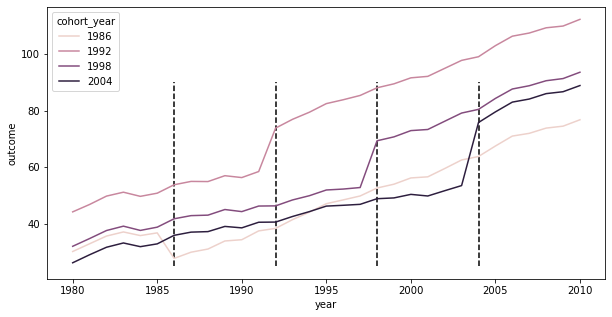

In [24]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
[plt.vlines(c, 25, 90, color="black", linestyles="--") for c in cohorts];

<AxesSubplot:xlabel='year', ylabel='x'>

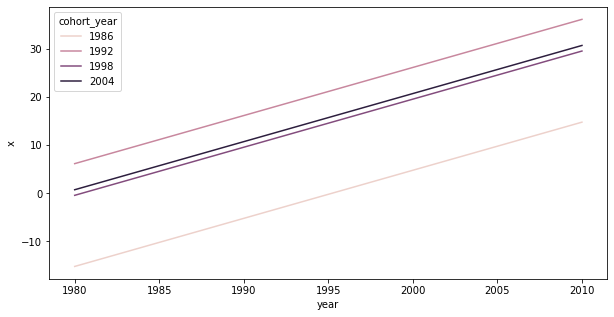

In [25]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["x"]].mean().reset_index(),
    x="year",
    y="x",
    hue="cohort_year",
)

In [26]:
formula = f"""outcome ~ treat + x + EntityEffects + TimeEffects"""

mod = PanelOLS.from_formula(formula, data=data.set_index(["unit", "year"]))

result = mod.fit(cov_type='clustered', cluster_entity=True)

result.summary.tables[1]

,Parameter,Std. Err.,T-stat,P-value,Lower CI,Upper CI
treat,10.611,3.3798,3.1396,0.0017,3.9867,17.236
x,-4.26e+04,5.24e+04,-0.8129,0.4163,-1.453e+05,6.011e+04


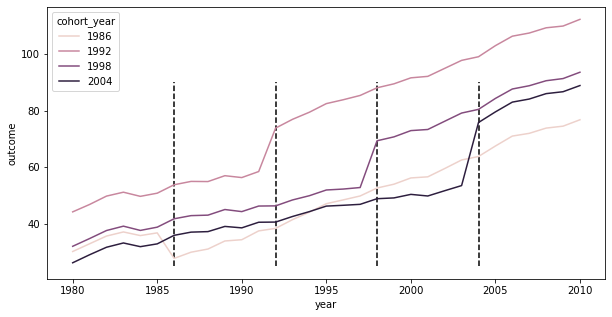

In [27]:
plt.figure(figsize=(10,5))
sns.lineplot(
    data=data.groupby(["year", "cohort_year"])[["outcome"]].mean().reset_index(),
    x="year",
    y="outcome",
    hue="cohort_year",
)
[plt.vlines(c, 25, 90, color="black", linestyles="--") for c in cohorts];